In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Functions for Linear Regression

In [2]:
# Create function to fit, make predictions and output results of linear regression
def fit_linear_reg(X_train, y_train, X_test, y_test):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    print('R2 Score:',metrics.r2_score(y_train, y_hat_train))
    print('RMSE Train:',np.sqrt(metrics.mean_squared_error(y_train, y_hat_train)))
    print('RMSE Test:',np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
    X_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_int).fit()
    return model.summary()

# Regression on Airbnb Price

In [3]:
# airbnb_data = pd.read_csv("large_clean_data/airbnb_model_data_clean.csv", index_col=0)

In [4]:
airbnb_data = pd.read_csv('cleaned_data/current_listing_availability.csv', index_col=0)

In [5]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6137 entries, 0 to 6136
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      6137 non-null   object 
 1   id                                6137 non-null   int64  
 2   host_id                           6137 non-null   int64  
 3   host_is_superhost                 6137 non-null   int64  
 4   zipcode                           6137 non-null   float64
 5   latitude                          6137 non-null   float64
 6   longitude                         6137 non-null   float64
 7   accommodates                      6137 non-null   int64  
 8   bathrooms                         6137 non-null   float64
 9   beds                              6137 non-null   float64
 10  price                             6137 non-null   float64
 11  minimum_nights                    6137 non-null   float64
 12  maximu

## Prepare Data for Modeling

In [6]:
# need to drop columns that are highly correlated

airbnb_data.drop(columns=['zipcode','latitude','longitude','availability_30','availability_60',
                          'availability_90','number_of_reviews','review_scores_accuracy',
                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                          'review_scores_location','review_scores_value',
                          'calculated_host_listings_count','occ_rate','monthly_income'],inplace=True)

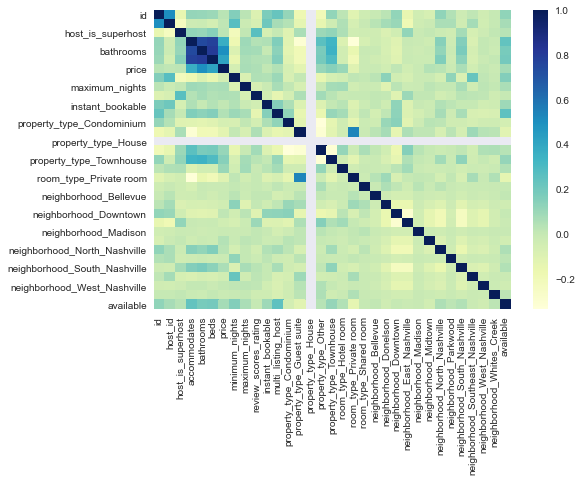

In [7]:
heatmap = sns.heatmap(airbnb_data.corr(), cmap='YlGnBu', annot=False)

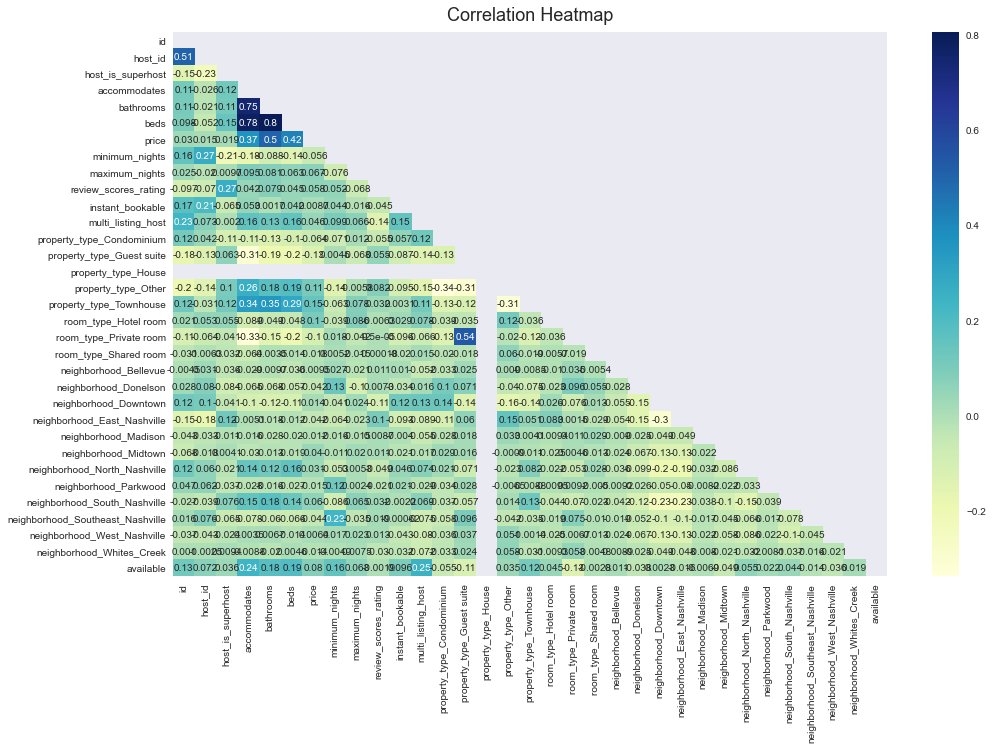

In [8]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(airbnb_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(airbnb_data.corr(), mask=mask, cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [9]:
airbnb_data.drop(columns=['property_type_House'],inplace=True)

In [10]:
airbnb_data

last_scraped        id    host_id  host_is_superhost  accommodates  \
0      2021-02-20      6422      12172                  1             2   
1      2021-02-20     25613      95811                  1             2   
2      2021-02-20    136015     666322                  0             2   
3      2021-02-20    258817      22296                  1             2   
4      2021-02-20    289242      22296                  1             1   
...           ...       ...        ...                ...           ...   
6132   2021-02-20  48207668  368944610                  0             5   
6133   2021-02-21  48208643  359230893                  0             5   
6134   2021-02-20  48211893  153902467                  0             2   
6135   2021-02-20  48224293  368944610                  0             3   
6136   2021-02-20  48226977   60934272                  0             8   

      bathrooms  beds  price  minimum_nights  maximum_nights  ...  \
0           1.0   3.0   40.0            30.0           365.0  ...   
1           1.0   1.0   75.0             2.0            30.0  ...   
2           1.0   1.0  103.0            30.0          1125.0  ...   
3           1.0   2.0   27.0            30.0           365.0  ...   
4           1.0   3.0   24.0            30.0           365.0  ...   
...         ...   ...    ...             ...             ...  ...   
6132        1.0   2.0  148.0            90.0           365.0  ...   
6133        2.0   2.0  139.0            30.0           365.0  ...   
6134        2.0   2.0   48.0            30.0            90.0  ...   
6135        1.0   1.0  121.0            90.0           365.0  ...   
6136        2.0   3.0  151.0             1.0            29.0  ...   

      neighborhood_East_Nashville  neighborhood_Madison  neighborhood_Midtown  \
0                               1                     0                     0   
1                               1                     0                     0   
2                               0                     0                     0   
3                               0                     0                     0   
4                               0                     0                     0   
...                           ...                   ...                   ...   
6132                            0                     0                     0   
6133                            0                     0                     0   
6134                            0                     0                     0   
6135                            0                     0                     0   
6136                            1                     0                     0   

      neighborhood_North_Nashville  neighborhood_Parkwood  \
0                                0                      0   
1                                0                      0   
2                                0                      0   
3                                0                      0   
4                                0                      0   
...                            ...                    ...   
6132                             0                      0   
6133                             1                      0   
6134                             0                      0   
6135                             0                      0   
6136                             0                      0   

      neighborhood_South_Nashville  neighborhood_Southeast_Nashville  \
0                                0                                 0   
1                                0                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   
...                            ...                               ...   
6132                             0                               

In [11]:
# set up variables and drop non numerical columns
y = airbnb_data['price']
X = airbnb_data.drop(['last_scraped', 'id','host_id','price'], axis=1)

In [12]:
# perform train-test split using a test size of 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Run Baseline Model

In [13]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.3050340718391352
RMSE Train: 263.22248738968227
RMSE Test: 343.80166294166753


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     73.84
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:54:33   Log-Likelihood:                -34323.
No. Observations:                4909   AIC:                         6.871e+04
Df Residuals:                    4879   BIC:                         6.890e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             -220.1584     68.117     -3.232      0.001    -353.698     -86.619
host_is_superhost                  -32.3371      8.471     -3.818      0.000     -48.944     -15.731
accommodates                        -1.2802      1.996     -0.641      0.521      -5.194       2.634
bathrooms                          109.6778      4.916     22.309      0.000     100.039     119.316
beds                                 7.0388      1.991      3.536      0.000       3.136      10.942
minimum_nights                      -0.2181      0.254     -0.857      0.391      -0.717       0.281
maximum_nights                       0.0108      0.008      1.394      0.163      -0.004       0.026
review_scores_rating                 1.9572      0.665      2.943      0.003       0.653       3.261
instant_bookable                     0.4602      7.903      0.058      0.954     -15.033      15.953
multi_listing_host                 -21.7061      8.884     -2.443      0.015     -39.123      -4.289
property_type_Condominium          -15.8164     13.866     -1.141      0.254     -43.000      11.367
property_type_Guest suite          -17.0168     18.179     -0.936      0.349     -52.656      18.622
property_type_Other                 -5.9630     12.243     -0.487      0.626     -29.965      18.039
property_type_Townhouse            -22.8919     16.760     -1.366      0.172     -55.750       9.966
room_type_Hotel room               334.9269     38.515      8.696      0.000     259.420     410.434
room_type_Private room              -8.0283     15.973     -0.503      0.615     -39.344      23.287
room_type_Shared room              -66.8229     67.413     -0.991      0.322    -198.983      65.338
neighborhood_Bellevue               31.7145     43.471      0.730      0.466     -53.508     116.937
neighborhood_Donelson               40.8867     27.030      1.513      0.130     -12.105      93.878
neighborhood_Downtown               93.8829     24.917      3.768      0.000      45.035     142.731
neighborhood_East_Nashville         23.5516     24.397      0.965      0.334     -24.277      71.380
neighborhood_Madison                62.6905     46.807      1.339      0.181     -29.073     154.454
neighborhood_Midtown               119.1644     28.201      4.226      0.000      63.878     174.451
neighborhood_North_Nashville        15.8115     26.089      0.606      0.544     -35.334      66.957
neighborhood_Parkwood               38.1627     45.826      0.833      0.405     -51.677     128.002
neighborhood_South_Nashville        30.3501     25.324      1.198      0.231     -19.296      79.996
neighborhood_Southeast_Nashville    26.8951     31.400      0.857      0.392     -34.662      88.453
neighborhood_West_Nashville         51.7648     28.09

## Run Model Using Only most Correlated Features

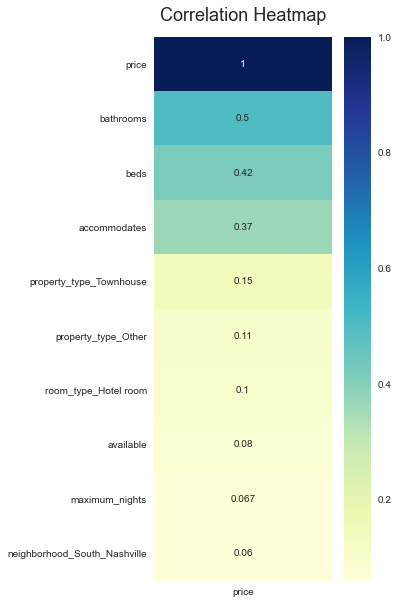

In [14]:
plt.figure(figsize=(4, 10))
#mask = np.triu(np.ones_like(regression_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(airbnb_data.corr()[['price']].sort_values(by='price', ascending=False)[:10],
                       cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [15]:
X_train = X_train[['bathrooms','beds','accommodates']]
X_test = X_test[['bathrooms','beds','accommodates']]

In [16]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.27732145994683166
RMSE Train: 268.41934452858544
RMSE Test: 352.52547287665357


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     627.4
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:54:34   Log-Likelihood:                -34419.
No. Observations:                4909   AIC:                         6.885e+04
Df Residuals:                    4905   BIC:                         6.887e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -9.1497      8.097     -1.130      0.259     -25.024       6.724
bathrooms      108.2144      4.823     22.438      0.000      98.759     117.669
beds             6.2288      1.991      3.129      0.002       2.326      10.131
accommodates    -3.0525      1.755     -1.739      0.082      -6.493       0.388
==============================================================================
Omnibus:                    11272.947   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        110381556.149
Skew:                          21.907   Prob(JB):                         0.00
Kurtosis:                     736.303   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Choose Model Features Using Stepwise Selection

In [17]:
y = airbnb_data['price']
X = airbnb_data.drop(['last_scraped', 'id','host_id','price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [19]:
new_x_cols = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(new_x_cols)

<ipython-input-18-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bathrooms                      with p-value 0.0
Add  room_type_Hotel room           with p-value 2.14691e-17
Add  neighborhood_Downtown          with p-value 1.5739e-10
Add  neighborhood_Midtown           with p-value 3.70025e-08
Add  multi_listing_host             with p-value 0.000823535
Add  beds                           with p-value 0.00152102
Add  host_is_superhost              with p-value 0.000532067
Add  review_scores_rating           with p-value 0.00488741
resulting features:
['bathrooms', 'room_type_Hotel room', 'neighborhood_Downtown', 'neighborhood_Midtown', 'multi_listing_host', 'beds', 'host_is_superhost', 'review_scores_rating']


In [20]:
X_train = X_train[new_x_cols]
X_test = X_test[new_x_cols]

In [21]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.30257856058573507
RMSE Train: 263.6870971133718
RMSE Test: 343.9929843768172


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     265.7
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:54:36   Log-Likelihood:                -34332.
No. Observations:                4909   AIC:                         6.868e+04
Df Residuals:                    4900   BIC:                         6.874e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -195.2708     63.038     -3.098      0.002    -318.854     -71.688
bathrooms               107.7555      4.535     23.763      0.000      98.866     116.645
room_type_Hotel room    340.3599     37.094      9.176      0.000     267.639     413.081
neighborhood_Downtown    70.9950      9.186      7.729      0.000      52.987      89.003
neighborhood_Midtown     93.7450     16.768      5.591      0.000      60.873     126.617
multi_listing_host      -26.6250      8.154     -3.265      0.001     -42.611     -10.639
beds                      6.4424      1.775      3.629      0.000       2.962       9.923
host_is_superhost       -32.6948      8.005     -4.084      0.000     -48.389     -17.001
review_scores_rating      1.8384      0.653      2.816      0.005       0.558       3.118
==============================================================================
Omnibus:                    11207.174   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        106034403.500
Skew:                          21.603   Prob(JB):                         0.00
Kurtosis:                     721.702   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression on Average Home Value

In [22]:
regression_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

In [23]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     float64
 12

In [24]:
regression_df.head()

id       host_id       zipcode   latitude  longitude  \
2015-06-01  4.911123e+06  1.847859e+07  37202.099174  36.161913 -86.768430   
2015-07-01  4.585624e+06  1.588542e+07  37202.203096  36.157222 -86.767316   
2015-08-01           NaN           NaN           NaN        NaN        NaN   
2015-09-01           NaN           NaN           NaN        NaN        NaN   
2015-10-01  5.435875e+06  1.857827e+07  37201.418483  36.156564 -86.767390   

            accommodates  bathrooms      beds       price  minimum_nights  \
2015-06-01      4.223140   1.450413  2.033058  163.115702        1.545455   
2015-07-01      4.607430   1.500310  2.308978  202.349226        1.698452   
2015-08-01           NaN        NaN       NaN         NaN             NaN   
2015-09-01           NaN        NaN       NaN         NaN             NaN   
2015-10-01      4.795735   1.528910  2.406161  200.524171        1.747867   

            ...  property_type_Condominium  property_type_Guest suite  \
2015-06-01  ...                        1.0                        0.0   
2015-07-01  ...                       33.0                        0.0   
2015-08-01  ...                        0.0                        0.0   
2015-09-01  ...                        0.0                        0.0   
2015-10-01  ...                       54.0                        0.0   

            property_type_House  property_type_Other  property_type_Townhouse  \
2015-06-01                 78.0                 11.0                      1.0   
2015-07-01               1048.0                100.0                     18.0   
2015-08-01                  0.0                  0.0                      0.0   
2015-09-01                  0.0                  0.0                      0.0   
2015-10-01               1360.0                130.0                     51.0   

            room_type_Hotel room  room_type_Private room  \
2015-06-01                   0.0                    39.0   
2015-07-01                   0.0                   451.0   
2015-08-01                   0.0                     0.0   
2015-09-01                   0.0                     0.0   
2015-10-01                   0.0                   566.0   

            room_type_Shared room  inventory  avg_home_value  
2015-06-01                    3.0        121        198388.0  
2015-07-01                   18.0       1615        199865.0  
2015-08-01                    0.0          0        201227.0  
2015-09-01                    0.0          0        202952.0  
2015-10-01                   30.0       2110        204617.0  

[5 rows x 50 columns]

In [25]:
regression_df.tail()

id       host_id       zipcode   latitude  longitude  \
2020-10-01  2.947930e+07  1.089430e+08  37202.054170  36.161081 -86.769555   
2020-11-01  2.973666e+07  1.117253e+08  37202.339950  36.160847 -86.770116   
2020-12-01  3.052512e+07  1.180080e+08  37202.158459  36.160308 -86.769276   
2021-01-01  3.076033e+07  1.189754e+08  37201.965274  36.160225 -86.769192   
2021-02-01  3.121712e+07  1.218997e+08  37202.099397  36.160393 -86.768885   

            accommodates  bathrooms      beds       price  minimum_nights  \
2020-10-01      6.279273   1.918002  3.715442  212.609249        5.055161   
2020-11-01      6.231287   1.910765  3.692683  211.482086        5.151051   
2020-12-01      6.198440   1.911263  3.645701  212.335529        7.567203   
2021-01-01      6.205242   1.913022  3.651761  196.913186        7.313186   
2021-02-01      6.234968   1.926104  3.667916  204.767965        7.553854   

            ...  property_type_Condominium  property_type_Guest suite  \
2020-10-01  ...                      747.0                      672.0   
2020-11-01  ...                      749.0                      652.0   
2020-12-01  ...                      747.0                      639.0   
2021-01-01  ...                      748.0                      636.0   
2021-02-01  ...                      756.0                      636.0   

            property_type_House  property_type_Other  property_type_Townhouse  \
2020-10-01                  0.0               2800.0                    629.0   
2020-11-01                  0.0               2739.0                    604.0   
2020-12-01                  0.0               2754.0                    650.0   
2021-01-01                  0.0               2743.0                    646.0   
2021-02-01                  0.0               2745.0                    665.0   

            room_type_Hotel room  room_type_Private room  \
2020-10-01                  73.0                   681.0   
2020-11-01                  74.0                   652.0   
2020-12-01                  73.0                   650.0   
2021-01-01                  76.0                   640.0   
2021-02-01                  66.0                   652.0   

            room_type_Shared room  inventory  avg_home_value  
2020-10-01                   16.0       6055        298809.0  
2020-11-01                   18.0       5945        301461.0  
2020-12-01                   16.0       6153        304539.0  
2021-01-01                   17.0       6105        307585.0  
2021-02-01                   18.0       6137        310812.0  

[5 rows x 50 columns]

## Prepare Data for Modeling

In [26]:
regression_df.dropna(inplace=True)

In [27]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 2015-06-01 to 2021-02-01
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     float64
 12

In [28]:
# drop columns that could be calculated by using other columns--too much similarity
regression_df.drop(columns=['zipcode','latitude','longitude','availability_30','availability_60',
                          'availability_90','review_scores_accuracy',
                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                          'review_scores_location','review_scores_value','calculated_host_listings_count',
                            'occ_rate','monthly_income'],inplace=True)

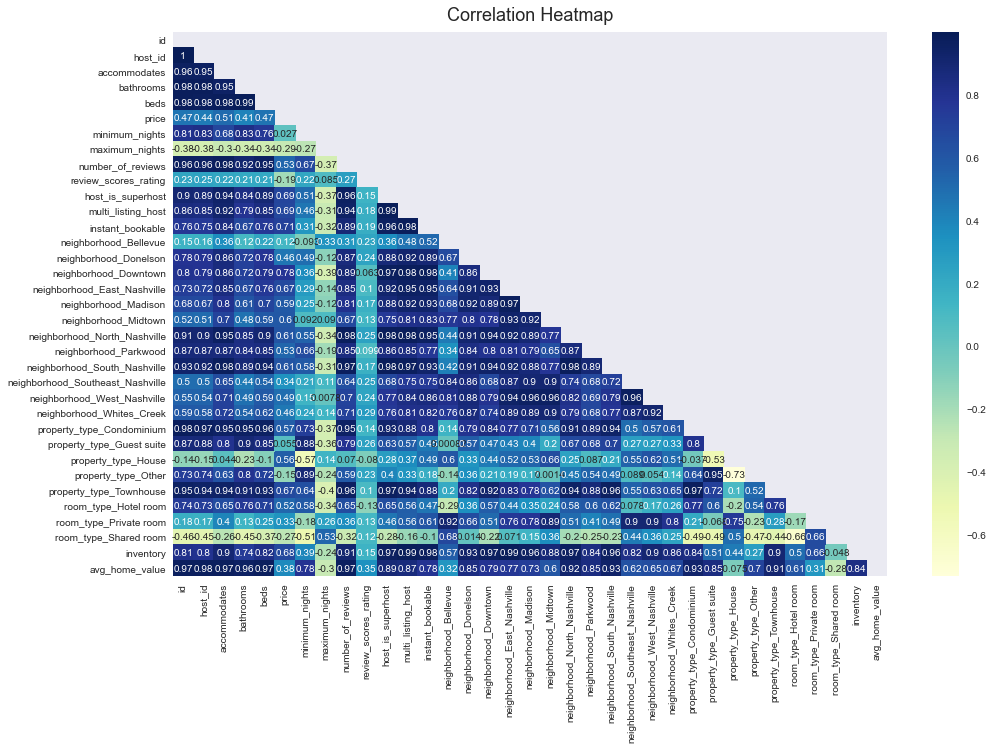

In [29]:
# review correlation between the remaining columns
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(regression_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(regression_df.corr(), mask=mask, cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

There are clearly many features correlated with each other in the data.

## Run Baseline Model

In [30]:
y = regression_df['avg_home_value']
X = regression_df.drop(['host_id','id','avg_home_value'], axis=1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [32]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 1.0
RMSE Train: 7.993987846232593e-07
RMSE Test: 3287.3176000703916


C:\Users\saman\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\saman\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1698: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\saman\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\saman\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                nan
Time:                        18:54:39   Log-Likelihood:                 343.55
No. Observations:                  31   AIC:                            -625.1
Df Residuals:                       0   BIC:                            -580.7
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             7332.3605        inf          0        nan         nan         nan
accommodates                      1.153e+05        inf          0        nan         nan         nan
bathrooms                          1.84e+04        inf          0        nan         nan         nan
beds                              -5.35e+04        inf         -0        nan         nan         nan
price                             -224.6910        inf         -0        nan         nan         nan
minimum_nights                   -6293.6253        inf         -0        nan         nan         nan
maximum_nights                       0.0040        inf          0        nan         nan         nan
number_of_reviews                 -583.0495        inf         -0        nan         nan         nan
review_scores_rating             -1568.6816        inf         -0        nan         nan         nan
host_is_superhost                  -33.2872        inf         -0        nan         nan         nan
multi_listing_host                  18.9285        inf          0        nan         nan         nan
instant_bookable                     6.4132        inf          0        nan         nan         nan
neighborhood_Bellevue             -350.8486        inf         -0        nan         nan         nan
neighborhood_Donelson              232.4080        inf          0        nan         nan         nan
neighborhood_Downtown              184.0937        inf          0        nan         nan         nan
neighborhood_East_Nashville         90.6486        inf          0        nan         nan         nan
neighborhood_Madison             -1244.1372        inf         -0        nan         nan         nan
neighborhood_Midtown               163.7542        inf          0        nan         nan         nan
neighborhood_North_Nashville        62.0504        inf          0        nan         nan         nan
neighborhood_Parkwood              -39.4438        inf         -0        nan         nan         nan
neighborhood_South_Nashville       173.5223        inf          0        nan         nan         nan
neighborhood_Southeast_Nashville   354.6522        inf          0        nan         nan         nan
neighborhood_West_Nashville        454.1778        inf          0        nan         nan         nan
neighborhood_Whites_Creek          110.2866        inf          0        nan         nan         nan
property_type_Condominium           39.6587        inf          0        nan         nan         nan
property_type_Guest suite         -234.6080        inf         -0        nan         nan         nan
property_type_House                 95.6249        inf          0        nan         nan         nan
property_type_Other                157.5820        in

Our model is extremely overfit to the training data.

Using this many features has severely overfit our data. We have more variables than datapoints.

Because there is so much multicollinearity present, let's see if performing PCA will improve our model.

## PCA

In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pc_train = pca.fit_transform(X_train)
pc_test = pca.transform(X_test)


In [35]:
fit_linear_reg(pc_train, y_train, pc_test, y_test)

R2 Score: 0.9537387511740494
RMSE Train: 6089.152332022923
RMSE Test: 5851.429731538603


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     185.5
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           3.98e-18
Time:                        18:54:39   Log-Likelihood:                -314.13
No. Observations:                  31   AIC:                             636.3
Df Residuals:                      27   BIC:                             642.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.707e+05   1171.858    231.022      0.000    2.68e+05    2.73e+05
x1            -0.0605      0.008     -7.568      0.000      -0.077      -0.044
x2            -7.7326      0.409    -18.912      0.000      -8.572      -6.894
x3            10.2405      0.860     11.903      0.000       8.475      12.006
==============================================================================
Omnibus:                       13.200   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                2.698
Skew:                           0.106   Prob(JB):                        0.260
Kurtosis:                       1.571   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using PCA with 3 components, we are able to get an R2 value of 0.95.

## Run Simple Regression Model

In [36]:
y = regression_df['avg_home_value']
X = regression_df[['number_of_reviews']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.941988705477432
RMSE Train: 6818.744869142594
RMSE Test: 6879.297392495575


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     470.9
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           1.78e-19
Time:                        18:54:39   Log-Likelihood:                -317.64
No. Observations:                  31   AIC:                             639.3
Df Residuals:                      29   BIC:                             642.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.622e+05   5160.574     31.423      0.000    1.52e+05    1.73e+05
number_of_reviews  2427.1634    111.849     21.700      0.000    2198.406    2655.921
==============================================================================
Omnibus:                        2.740   Durbin-Watson:                   1.485
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.112
Skew:                           0.638   Prob(JB):                        0.348
Kurtosis:                       2.913   Cond. No.                         188.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We are able to obtain an R2 score of .94 using only the number of reviews, and we have now addressed the multicollinearity problem.

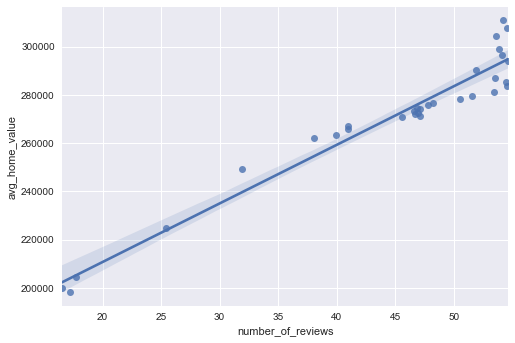

In [37]:
sns.regplot(X_train,y_train)

Using only the number of reviews, we were able to predict the average home value with 94% accuracy within $6800. Our test RMSE is also very close to our train RMSE, meaning our model is not overfit.

### Perform Cross-Validation

In [38]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
from sklearn.metrics import mean_squared_error, make_scorer
mse = make_scorer(mean_squared_error)

cv_20_results = cross_val_score(model, X,y, cv=20, scoring=mse)
np.mean(np.sqrt(cv_20_results))

6505.28149432814

### Check for Assumptions of Linear Regression

In [40]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()

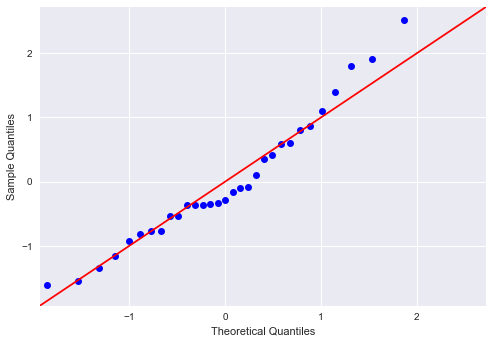

In [41]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

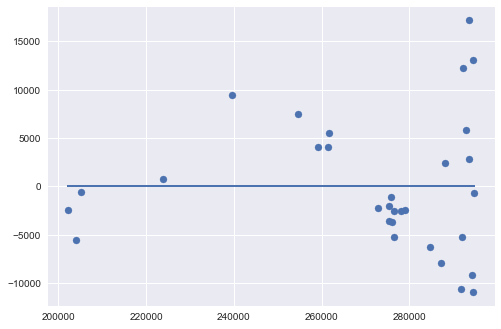

In [42]:
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_int))]);

It looks like our assumptions of linear regression hold up for the most part.

## Run Model Using Only Most Correlated Features

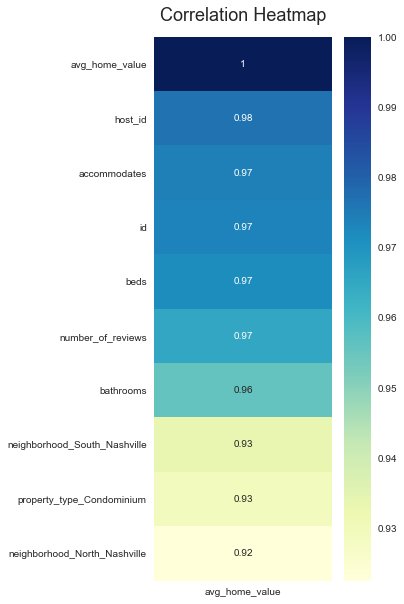

In [43]:
plt.figure(figsize=(4, 10))
#mask = np.triu(np.ones_like(regression_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(regression_df.corr()[['avg_home_value']].sort_values(by='avg_home_value', ascending=False)[:10],
                       cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [44]:
X_cols_2 = list(regression_df.corr()[['avg_home_value']].sort_values(by='avg_home_value', ascending=False)[:12].index)

In [46]:
to_remove = ['avg_home_value','host_id','id']

X_cols_2 = [x for x in X_cols_2 if x not in to_remove]
X_cols_2

['accommodates',
 'beds',
 'number_of_reviews',
 'bathrooms',
 'neighborhood_South_Nashville',
 'property_type_Condominium',
 'neighborhood_North_Nashville',
 'property_type_Townhouse',
 'host_is_superhost']

In [47]:
y = regression_df['avg_home_value']
X = regression_df.drop(['host_id','id','avg_home_value'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [48]:
X_train = X_train[X_cols_2]
X_test = X_test[X_cols_2]

In [49]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.9875706601004909
RMSE Train: 3156.2558108753637
RMSE Test: 3627.5364791950456


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     185.4
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           5.94e-18
Time:                        18:57:03   Log-Likelihood:                -293.76
No. Observations:                  31   AIC:                             607.5
Df Residuals:                      21   BIC:                             621.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5603.5364   1.34e+05      0.042      0.967   -2.74e+05    2.85e+05
accommodates                  1.043e+04   2.74e+04      0.381      0.707   -4.65e+04    6.73e+04
beds                         -8895.7882   4.74e+04     -0.188      0.853   -1.08e+05    8.98e+04
number_of_reviews             1672.1998    631.065      2.650      0.015     359.827    2984.572
bathrooms                     9.321e+04   1.16e+05      0.801      0.432   -1.49e+05    3.35e+05
neighborhood_South_Nashville    20.0681     46.541      0.431      0.671     -76.720     116.856
property_type_Condominium      -11.3082     26.588     -0.425      0.675     -66.601      43.985
neighborhood_North_Nashville    85.1413     39.364      2.163      0.042       3.279     167.003
property_type_Townhouse         10.5794     30.441      0.348      0.732     -52.726      73.885
host_is_superhost              -22.4385      8.245     -2.722      0.013     -39.584      -5.293
==============================================================================
Omnibus:                        2.062   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.567
Skew:                          -0.366   Prob(JB):                        0.457
Kurtosis:                       2.177   Cond. No.                     9.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our RMSE Test and Train scores have moved much closer together, and our R2 is still extremely high.

There are some features in this model with p-values above 0.05. Let's try using stepwise selection to select our features based on p-values instead.

## Choose Model Features Using Stepwise Selection

In [50]:
#y = regression_df['avg_home_value']
#X = regression_df.drop(['host_id','id','avg_home_value'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [51]:
new_x_cols = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(new_x_cols)

<ipython-input-18-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  beds                           with p-value 1.41249e-20
Add  review_scores_rating           with p-value 0.000164493
Add  neighborhood_Donelson          with p-value 0.000102677
Add  minimum_nights                 with p-value 3.86522e-06
Add  bathrooms                      with p-value 0.00514459
resulting features:
['beds', 'review_scores_rating', 'neighborhood_Donelson', 'minimum_nights', 'bathrooms']


In [52]:
X_train = X_train[new_x_cols]
X_test = X_test[new_x_cols]

In [53]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.9948072505146451
RMSE Train: 2040.0783565677252
RMSE Test: 4377.952222035657


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     957.9
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           1.05e-27
Time:                        18:57:06   Log-Likelihood:                -280.23
No. Observations:                  31   AIC:                             572.5
Df Residuals:                      25   BIC:                             581.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.143e+06   2.76e+05     -7.777      0.000   -2.71e+06   -1.58e+06
beds                   7.777e+04   1.21e+04      6.408      0.000    5.28e+04    1.03e+05
review_scores_rating    2.44e+04   2833.650      8.611      0.000    1.86e+04    3.02e+04
neighborhood_Donelson    51.9516      9.142      5.682      0.000      33.122      70.781
minimum_nights         4538.5151    703.651      6.450      0.000    3089.319    5987.711
bathrooms             -1.292e+05   4.21e+04     -3.066      0.005   -2.16e+05   -4.24e+04
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.590
Skew:                          -0.090   Prob(JB):                        0.745
Kurtosis:                       2.349   Cond. No.                     2.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using stepwise selection makes our model overfit to the training data. The first model we ran with the top correlated features performed strongest. We will remove the features with p-values above 0.05 and check our results.

## Run Model with Significant features from Model 2

In [54]:
# y = regression_df['avg_home_value']
# X = regression_df.drop(['host_id','id','avg_home_value'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [55]:
X_train = X_train[X_cols_2]
X_test = X_test[X_cols_2]

In [56]:
X_cols_4 = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(X_cols_4 )

<ipython-input-18-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  beds                           with p-value 1.41249e-20
Add  number_of_reviews              with p-value 0.00132124
Add  host_is_superhost              with p-value 0.000676835
Add  neighborhood_North_Nashville   with p-value 0.000449274
resulting features:
['beds', 'number_of_reviews', 'host_is_superhost', 'neighborhood_North_Nashville']


In [57]:
X_train = X_train[X_cols_4]
X_test = X_test[X_cols_4]

In [58]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.9866233208809887
RMSE Train: 3274.329021034559
RMSE Test: 4056.0740622305684


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     479.4
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           6.07e-24
Time:                        18:57:07   Log-Likelihood:                -294.90
No. Observations:                  31   AIC:                             599.8
Df Residuals:                      26   BIC:                             607.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         9.487e+04   9379.293     10.115      0.000    7.56e+04    1.14e+05
beds                          3.546e+04   5916.089      5.994      0.000    2.33e+04    4.76e+04
number_of_reviews             1660.2363    409.905      4.050      0.000     817.665    2502.808
host_is_superhost              -21.2863      3.439     -6.189      0.000     -28.356     -14.217
neighborhood_North_Nashville    92.0999     22.938      4.015      0.000      44.951     139.249
==============================================================================
Omnibus:                        1.276   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                0.990
Skew:                          -0.163   Prob(JB):                        0.610
Kurtosis:                       2.187   Cond. No.                     5.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model is less overfit than the previous model and has less insignificant features included than the model with the most correlated features. We will proceed with this model as our final model.

## Check for Assumptions of Linearity

In [59]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()

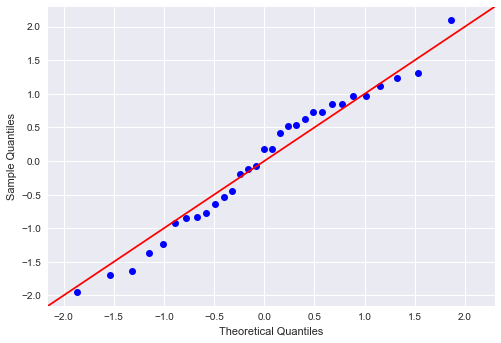

In [60]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

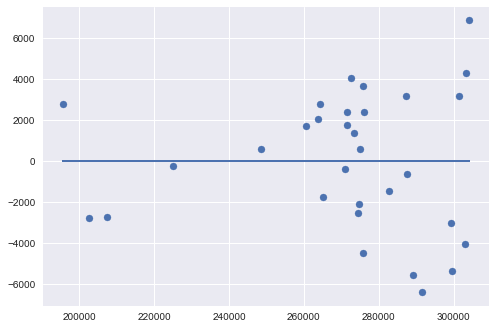

In [61]:
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_int))]);

It looks like the assumptions of linear regression are generally met.

In [62]:
feature_cols = list(X_train.columns)

In [63]:
y = regression_df['avg_home_value']
X = regression_df[feature_cols]
final_reg_features_df = pd.concat([y,X], axis=1)

In [64]:
final_reg_features_df

avg_home_value      beds  number_of_reviews  host_is_superhost  \
2015-06-01        198388.0  2.033058          17.206612                 23   
2015-07-01        199865.0  2.308978          16.536223                286   
2015-10-01        204617.0  2.406161          17.715640                434   
2016-09-01        224658.0  2.602991          25.443699                974   
2017-09-01        249172.0  2.836834          31.943173               1961   
2018-04-01        262160.0  3.054797          38.099596               2376   
2018-05-01        263200.0  3.071048          39.961143               2380   
2018-07-01        265646.0  3.114947          40.941241               2666   
2018-08-01        267141.0  3.102364          40.988182               2738   
2018-09-01        268481.0  3.098633          42.363731               2718   
2018-10-01        269740.0  3.000171          43.922526               2839   
2018-11-01        270601.0  3.066374          45.616281               2932   
2018-12-01        271199.0  3.082217          47.102390               2944   
2019-01-01        271835.0  3.127876          46.678560               3161   
2019-02-01        272519.0  3.147395          46.975848               3180   
2019-03-01        273319.0  3.203883          46.617638               3225   
2019-04-01        273929.0  3.224996          47.079982               3450   
2019-05-01        274656.0  3.203968          46.818792               3532   
2019-06-01        275588.0  3.269071          47.761241               3572   
2019-07-01        276659.0  3.249826          48.191830               3876   
2019-08-01        277592.0  3.265536          49.482692               3831   
2019-09-01        278427.0  3.323033          50.498421               3952   
2019-10-01        279309.0  3.336951          51.544493               4240   
2019-11-01        280372.0  3.358999          53.331394               4284   
2019-12-01        281289.0  3.398932          53.452870               4302   
2020-01-01        282420.0  3.407407          54.235678               4235   
2020-02-01        283604.0  3.493658          54.547437               4357   
2020-03-01        285216.0  3.552430          54.464739               4333   
2020-04-01        286807.0  3.528644          53.517751               4306   
2020-05-01        288677.0  3.589985          52.307336               4170   
2020-06-01        290436.0  3.615508          51.865362               3977   
2020-07-01        292234.0  3.603293          51.398054               3965   
2020-08-01        294138.0  3.690015          54.663463               3770   
2020-09-01        296361.0  3.728288          54.136759               3751   
2020-10-01        298809.0  3.715442          53.884558               3533   
2020-11-01        301461.0  3.692683          54.217325               3429   
2020-12-01        304539.0  3.645701          53.611572               3495   
2021-01-01        307585.0  3.651761          54.542506               3497   
2021-02-01        310812.0  3.667916          54.167183               3515   

            neighborhood_North_Nashville  
2015-06-01                           6.0  
2015-07-01                          49.0  
2015-10-01                          76.0  
2016-09-01                         176.0  
2017-09-01                         454.0  
2018-04-01                         484.0  
2018-05-01                         494.0  
2018-07-01                         511.0  
2018-08-01                         540.0  
2018-09-01                         523.0  
2018-10-01                         563.0  
2018-11-01                         587.0  
2018-12-01                         608.0  
2019-01-01                         634.0  
2019-02-01                         628.0  
2019-03-01                         590.0  
2019-04-01                         625.0  
2019-05-01                         676.0  
2019-06-01                         662.0  
2019-07-01                     

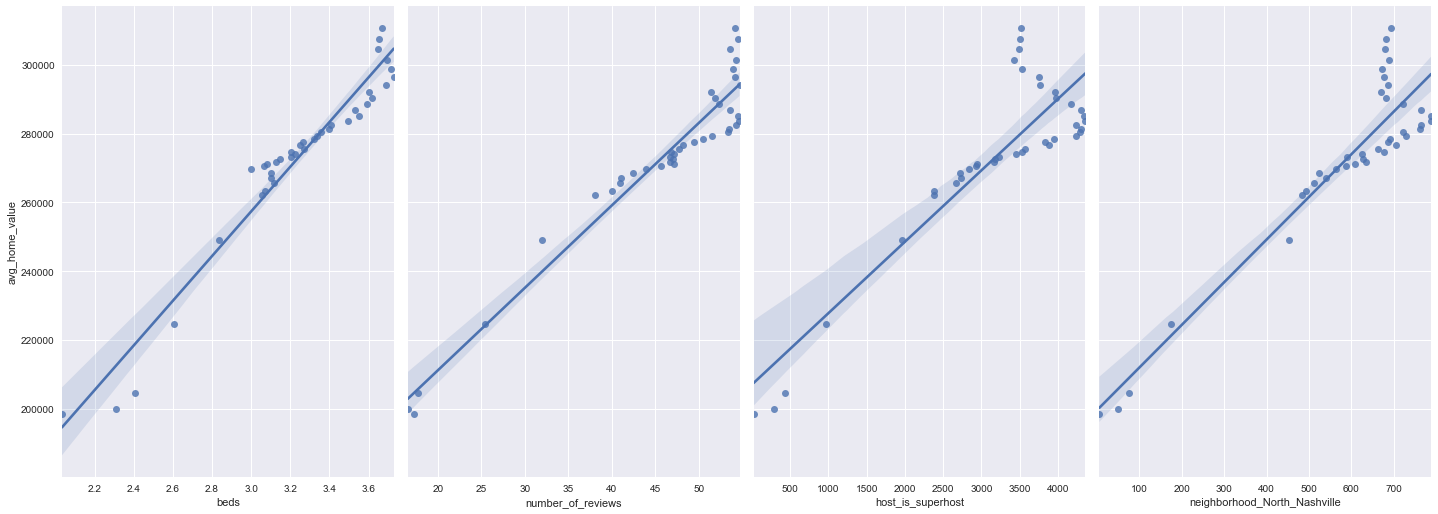

In [65]:
sns.pairplot(final_reg_features_df, x_vars=X_cols_4, 
             y_vars='avg_home_value', height=7, aspect=0.7, kind='reg');

In [66]:
model_final = LinearRegression()
model_final.fit(X_train, y_train)
y_hat_train = model_final.predict(X_train)
y_hat_test = model_final.predict(X_test)
metrics.r2_score(y_train, y_hat_train)

0.9866233208809887

In [67]:
mse = make_scorer(mean_squared_error)

cv_20_results = cross_val_score(model_final, X,y, cv=20, scoring=mse)
np.mean(np.sqrt(cv_20_results))

3917.499111156397

In [68]:
model_final.coef_

array([ 3.54602491e+04,  1.66023625e+03, -2.12862841e+01,  9.20998884e+01])

In [69]:
coeff_df = pd.DataFrame(model_final.coef_, X.columns, columns = ['Coeff'])

In [70]:
coeff_df

Coeff
beds                          35460.249059
number_of_reviews              1660.236253
host_is_superhost               -21.286284
neighborhood_North_Nashville     92.099888

In [83]:
colors = ['#E42524', '#F4AA9E', '#008D8A', '#E3F9F7']

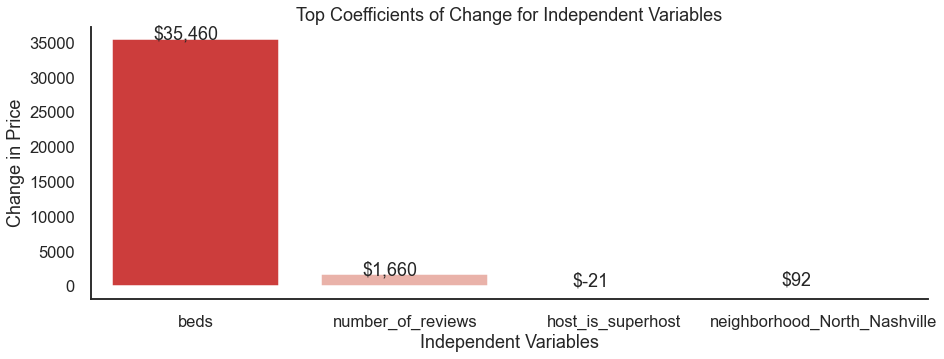

In [87]:
sns.set_palette(sns.color_palette(colors))
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(15,5))
ax = sns.barplot(x = coeff_df.index, y = coeff_df['Coeff'], 
            data=coeff_df)
ax.set_title('Top Coefficients of Change for Independent Variables')
ax.set(xlabel='Independent Variables', ylabel= 'Change in Price')

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x()+(width/4),
            y = height+.25,
            s = '${:,.0f}'.format(height)) 
#plt.savefig('images/top_coefficents.png')
sns.despine()

In [72]:
final_reg_features_df.to_csv("cleaned_data/final_reg_features.csv")